## Custom Linearizer

In [312]:
import torch
from torch import Tensor
from torch.nn import Module, Sequential, Linear, SiLU, GELU, LayerNorm
import matplotlib.pyplot as plt
from matplotlib import cm
from torchdiffeq import odeint
import math
import numpy as np

In [313]:
class TimeEmbedding(Module):
    def __init__(self, dim=16, max_freq=10.0):
        super().__init__()
        self.dim = dim
        self.freqs = torch.linspace(1.0, max_freq, dim // 2)

    def forward(self, t):
        freqs = self.freqs.to(t.device)  # [dim//2]
        t_proj = t * freqs * 2 * math.pi  # [B, dim//2]
        emb = torch.cat([torch.sin(t_proj), torch.cos(t_proj)], dim=1)  # [B, dim]
        return emb


class A(Module):
    def __init__(self, out_features=2, h_dim=1028, t_emb_dim=16):
        super().__init__()
        self.time_emb = TimeEmbedding(dim=t_emb_dim)
        self.A_net = Sequential(
            Linear(t_emb_dim, h_dim), SiLU(),
            Linear(h_dim, h_dim),     SiLU(),
            Linear(h_dim, h_dim),     SiLU(),
            Linear(h_dim, h_dim),     SiLU(),
            Linear(h_dim, out_features * out_features)
        )


    def forward(self, x, t):      
        t_emb = self.time_emb(t)
        A = self.A_net(t_emb).reshape(-1,2,2)
        x_pred = torch.bmm(x.reshape(x.shape[0],1,-1), A)
        x_pred = x_pred.reshape(x.shape)
        return x_pred, A
    

In [314]:
class AffineCoupling(Module):
    """
    y1 = (x1 + shift(x2)) * exp(clamp(log_s(x2)))
    inverse: x1 = y1 * exp(-clamp(log_s(x2))) - shift(x2)
    """

    def __init__(self, clamp: float = 5.0):
        super().__init__()
        self.cond = Conditioner()  
        self.clamp = clamp

    def _shift_log_scale(self, x_cond):
        h = self.cond(x_cond) 
        shift, log_s = torch.chunk(h, 2, dim=1)
        log_s = torch.clamp(log_s, -self.clamp, self.clamp)
        return shift, log_s

    def forward(self, x1, x2):
        shift, log_s = self._shift_log_scale(x2)
        return (x1 + shift) * torch.exp(log_s)

    def inverse(self, y1, x2):
        shift, log_s = self._shift_log_scale(x2)
        return y1 * torch.exp(-log_s) - shift
    
class Conditioner(Module):
    
    def __init__(self, h_dim = 1024):
        super().__init__()
        self.net = Sequential(
            Linear(1, h_dim),     SiLU(),
            Linear(h_dim, h_dim), SiLU(),
            Linear(h_dim, h_dim), SiLU(),
            Linear(h_dim, h_dim), SiLU(),
            Linear(h_dim, 2)
        ) 
        
    def forward(self, x):
        return self.net(x)

In [315]:
class G(Module):

    def __init__(self):
        super().__init__()

        self.F = AffineCoupling()
        self.G = AffineCoupling()


    def forward(self, X):  
        x1, x2 = X.chunk(2, dim=1)
        y1 = self.F(x1, x2)
        y2 = self.G(x2, y1)
        Y = torch.cat([y1, y2], dim=1)
        return Y

    def inverse(self, Y):
        y1, y2 = Y.chunk(2, dim=1)
        x2 = self.G.inverse(y2, y1)
        x1 = self.F.inverse(y1, x2)
        X = torch.cat([y1 := x1, y2 := x2], dim=1)  
        return X

In [316]:
class FlowMatcher(Module):
    def __init__(self):
        super().__init__()
        self.gx = G()
        self.gy = G()
        self.A = A()
        
    def forward(self, x ,t):
        x_pred,_ = self.A(self.gx(x), t)
        return self.gy.inverse(x_pred)

In [317]:
def gen_data(batch_size, device='cpu'):
    x = 2 * torch.rand((batch_size, 1), device=device)
    y = torch.rand_like(x, device=device) + torch.floor(x)

    x1 = torch.cat([x, y], dim=1) - 1
    x0 = torch.randn_like(x1)
    return x0, x1

In [318]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 20
batch_size = 512


iterations = int(1e2)
lr = 1e-3
model = FlowMatcher()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr)
loss = torch.nn.functional.mse_loss
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=0)

for epoch in range(epochs):
    tot_loss = []
    for _ in range(iterations):
        optimizer.zero_grad()
        
        x0, x1 = gen_data(batch_size=batch_size, device=device)
        t = torch.rand((batch_size, 1), device=device)
        
        # Induced space embedding
        g_x0 = model.gy(x0)
        g_x1 = model.gx(x1)
        
        g_xt = g_x0 * (1 - t) + g_x1 * t

        # Model predition and loss computation
        gx_pred , _ = model.A(g_xt, t)
        fm_loss = loss(gx_pred, g_x1) # Not flow matching
        
        # Paper suggested reconstruction noise
        g_x0 = g_x0 + torch.randn_like(g_x1) * 0.3
        g_x1 = g_x1 + torch.randn_like(g_x1) * 0.3
        x0_rec_loss = loss(model.gy.inverse(g_x0), x0)
        x1_rec_loss = loss(model.gx.inverse(g_x1), x1)
        aff_p_rec_loss = loss(model.gx.inverse(gx_pred), x1) 
        
        L = fm_loss + (x0_rec_loss + x1_rec_loss + aff_p_rec_loss)
        L.backward()
        optimizer.step()
        tot_loss.append(L.item())

    epoch_loss = Tensor(tot_loss).sum() / iterations
    scheduler.step(epoch_loss)
    print(f'| Epoch: {epoch+1}\t| Loss: {epoch_loss:.6f}\t|')
    torch.save({
        'model_state_dict': model.state_dict(),
        'optim_state_dict': optimizer.state_dict(),
        'epoch': epoch + 1
    }, './model.pth')

| Epoch: 1	| Loss: 0.561621	|
| Epoch: 2	| Loss: 0.521172	|
| Epoch: 3	| Loss: 0.516982	|
| Epoch: 4	| Loss: 0.514036	|
| Epoch: 5	| Loss: 0.513544	|
| Epoch: 6	| Loss: 0.513043	|
| Epoch: 7	| Loss: 0.509749	|
| Epoch: 8	| Loss: 0.507024	|
| Epoch: 9	| Loss: 0.510672	|
| Epoch: 10	| Loss: 0.503259	|
| Epoch: 11	| Loss: 0.503144	|
| Epoch: 12	| Loss: 0.501247	|
| Epoch: 13	| Loss: 0.502460	|
| Epoch: 14	| Loss: 0.502631	|
| Epoch: 15	| Loss: 0.503006	|
| Epoch: 16	| Loss: 0.503951	|
| Epoch: 17	| Loss: 0.504398	|
| Epoch: 18	| Loss: 0.500007	|
| Epoch: 19	| Loss: 0.502999	|
| Epoch: 20	| Loss: 0.503047	|


# Evaluation

In [319]:
def sample(x, device, steps=100):
    model.eval()

    with torch.no_grad():
        g_x = model.gy(x)  # g_x strat as g_y (the encoding of the noise)
        dt = 1.0 / steps

        for i in range(0, steps - 1):
            
            t = torch.full((g_x.shape[0],), i * dt, device=device).reshape(-1,1)

            # k1
            g_t_model, _ = model.A(g_x, t=t)
            k1 = (g_t_model - g_x) / (1 - t)

            # k2
            g_x_k2 = g_x + 0.5 * dt * k1
            t_k2 = t + 0.5 * dt
            g_t_model_k2, _ = model.A(g_x_k2, t=t_k2)
            k2 = (g_t_model_k2 - g_x_k2) / (1 - t_k2)

            # k3
            g_x_k3 = g_x + 0.5 * dt * k2
            g_t_model_k3, _ = model.A(g_x_k3, t=t_k2)
            k3 = (g_t_model_k3 - g_x_k3) / (1 - t_k2)

            # k4
            g_x_k4 = g_x + dt * k3
            t_k4 = t + dt
            g_t_model_k4, _ = model.A(g_x_k4, t=t_k4)
            k4 = (g_t_model_k4 - g_x_k4) / (1 - t_k4)

            # Update
            g_x = g_x + dt * (k1 + 2 * k2 + 2 * k3 + k4) / 6
            
        g_x = model.gx.inverse(g_x)
    return g_x

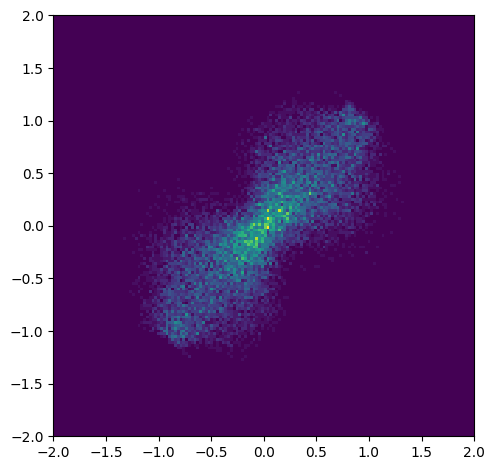

In [320]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = int(2e4)
x0 = torch.randn((batch_size, 2), device=device)
points = sample(x0, device=device).cpu()

plt.hist2d(points[:, 0], points[ :, 1], 150, range=((-2,2),(-2,2)))
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()